# 02-eff_n_issues_guardian

In [1]:
import numpy as np
import pandas as pd
from itertools import *

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = [7,8]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 17
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10

sns.set_context('talk')

from pprint import pprint

import imp

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

In [2]:
n_topics=50

words_per_topic     = pd.read_csv('guardian_data/topic_word_distributions_'+str(n_topics)+'topics.csv', index_col=0)
topics_per_document = pd.read_csv('guardian_data/document_topic_distributions_'+str(n_topics)+'topics.csv', index_col=0)

In [9]:
df_allnews = pd.DataFrame()
for year in range(2013,2019):
    infile = 'guardian_data/%d/allnews_%d.csv' % (year, year)
    df_year = pd.read_csv(infile, sep='\t')
    
    df_year = df_year[pd.notnull(df_year['text'])]
    df_year = df_year[df_year['text'].apply(len)>30]
        
    df_allnews = df_allnews.append(df_year)
    
df_allnews.head(3)

,headline,id,pubDate,sectionId,sectionName,text,trailText,webUrl
0,Fears for hostages as Algeria attacks gas comp...,world/middle-east-live/2013/jan/17/algerian-is...,2013-01-18T09:11:02Z,world,World news,We're closing this live blog but coverage will...,<p>• Reports of deaths of hostages and kidnapp...,https://www.theguardian.com/world/middle-east-...
1,Lance Armstrong admits doping in Oprah intervi...,sport/2013/jan/17/lance-armstrong-oprah-winfre...,2013-01-18T10:10:08Z,sport,Sport,"So, what did we learn here? • That Lance Armst...",<p>Lance Armstrong talks to Oprah Winfrey in h...,https://www.theguardian.com/sport/2013/jan/17/...
2,Venus Williams v Maria Sharapova – as it happened,sport/2013/jan/18/venus-williams-maria-sharapo...,2013-01-18T10:15:22Z,sport,Sport,"A few words from the victor: ""Both of us were ...",<p>Maria Sharapova was in brutal form as she d...,https://www.theguardian.com/sport/2013/jan/18/...


In [57]:
from datetime import date

def str2date(s):
    d = s[:10]
    year, month, day = [ int(i) for i in d.split('-') ]
    return date(year, month, day)

df_allnews['date']    = df_allnews.pubDate.apply(str2date)
df_allnews['year']    = df_allnews['date'].apply( lambda x: x.year )
df_allnews['month']   = df_allnews['date'].apply( lambda x: x.month )
df_allnews['day']     = df_allnews['date'].apply( lambda x: x.day )
df_allnews['isoyear'] = df_allnews['date'].apply( lambda x: x.isocalendar()[0] )
df_allnews['isoweek'] = df_allnews['date'].apply( lambda x: x.isocalendar()[1] )

In [58]:
def corrected_entropy(v, filler=1e-5):
    minv = min(v)
    v2 = [ i if i > minv else filler for i in v ]
    return entropy(v2)*entropy_fix

In [59]:
table = topics_per_document

all_entropies = []
n_issues = []

for index, row in table.iterrows():
    topic_array = np.array(row.values,dtype=np.float64)
    all_entropies += [ corrected_entropy(topic_array) ]
    minrow = min(row)
    n_issues      += [ sum(row.values>minrow) ]

all_entropies = np.array(all_entropies)
n_issues      = np.array(n_issues)

In [62]:
df_alldocs = df_allnews

doc_to_date = { row.id:(row.isoyear, row.isoweek) for _, row in df_alldocs.iterrows() }
all_dates = set(sorted(doc_to_date.values()))
all_documents = topics_per_document.index.values

from datetime import datetime
import time

dates = [ datetime.fromtimestamp(time.mktime(time.strptime('{} {} 1'.format(date[0],date[1]), '%Y %W %w'))) 
         for date in sorted(all_dates)]

In [63]:
table = topics_per_document

topics_per_date = {}

sorted_dates = []

for index, row in table.iterrows():
    topic_array = np.array(row.values,dtype=np.float64)
    date = doc_to_date[index]
    date = str(date[0])+'-'+str(date[1]).zfill(2)
    
    if date not in topics_per_date:
        topics_per_date[date]  = topic_array
        sorted_dates += [ date ]
    else:
        topics_per_date[date] += topic_array
        
sorted_dates = sorted(sorted_dates) 

In [64]:
eff_n_topics_per_date = [ 2**corrected_entropy(topics_per_date[date]) for date in sorted_dates ]

dates_x = [ datetime.fromtimestamp(time.mktime(time.strptime('{} {} 1'.format(date[:4],date[-2:]), '%Y %W %w')))  for date in sorted_dates]

In [149]:
df = pd.DataFrame({'date':sorted_dates, 'eff_n_topics_per_date':eff_n_topics_per_date})
df.to_csv('guardian_data/eff_n_topics_per_date.csv')

In [66]:
def running_mean(x, N=5):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

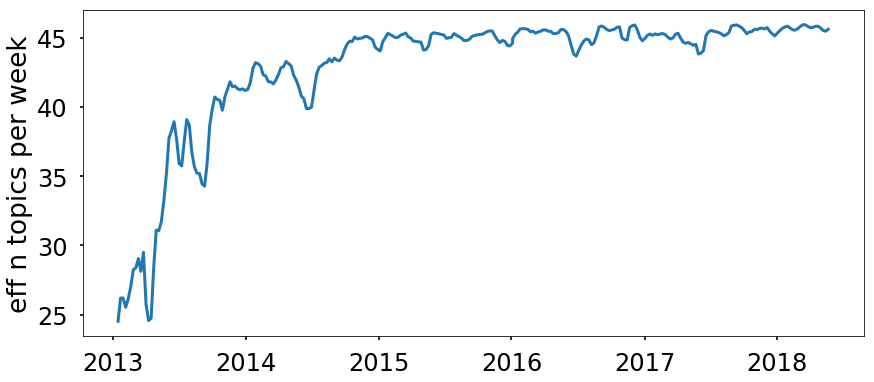

In [144]:
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})

#x = dates_x
#y = eff_n_topics_per_date

N = 3
x = dates_x[ int(N/2) : -int(N/2)]
y = running_mean(eff_n_topics_per_date, N=N)

plt.figure(figsize=(14,6))
plt.plot(x, y, lw=3);
plt.ylabel('eff n topics per week');

plt.savefig('Guardian-eff_n_topics_per_week.svg')
plt.show()

In [ ]:
# Now do the same per day

df_alldocs = df_allnews

doc_to_date2 = { row.id:(row.year, row.month, row.day) for _, row in df_alldocs.iterrows() }
all_dates2 = set(sorted(doc_to_date2.values()))
all_documents = topics_per_document.index.values

dates2 = [ datetime.fromtimestamp(
         time.mktime(time.strptime('{} {} {}'.format(date[0],date[1],date[2]), '%Y %m %d'))) 
         for date in sorted(all_dates2)]

In [126]:
table = topics_per_document

topics_per_date2 = {}

sorted_dates2 = []

for index, row in table.iterrows():
    topic_array = np.array(row.values,dtype=np.float64)
    date2 = doc_to_date2[index]
    date2 = str(date2[0])+'-'+str(date2[1]).zfill(2)+'-'+str(date2[2]).zfill(2)
    
    if date2 not in topics_per_date2:
        topics_per_date2[date2]  = topic_array
        sorted_dates2 += [ date2 ]
        #print("adding",date2,"to sorted_dates2")
    else:
        topics_per_date2[date2] += topic_array
        
sorted_dates2 = sorted(sorted_dates2)

In [127]:
eff_n_topics_per_date2 = [ 2**corrected_entropy(topics_per_date2[date2]) for date2 in sorted_dates2 ]

dates_x2 = [ datetime.fromtimestamp(time.mktime(time.strptime('{} {} {}'.format(date2[:4],date2[5:-3],date2[-2:]), '%Y %m %d')))
            for date2 in sorted_dates2]

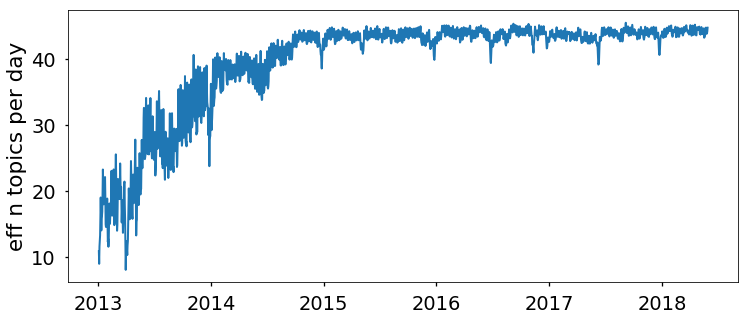

In [138]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

#x = dates_x2
#y = eff_n_topics_per_date2

N = 5
x = dates_x2[ int(N/2) : -int(N/2)]#[:20]
y = running_mean(eff_n_topics_per_date2, N=N)#[:20]

plt.figure(figsize=(12,5))
plt.plot(x, y, '-', lw=2);
plt.ylabel('eff n topics per day');

#plt.savefig('images-paper/Spiegel-eff_n_topics_per_week.svg')
plt.show()